<a href="https://colab.research.google.com/github/vishnu-096/Gait_Phase_Prediction/blob/main/lstm_and_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import sklearn
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf
import os
import time

import time
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import math
import matplotlib.pyplot as plt
import json
import math


In [ ]:
SEED = 13
tf.random.set_seed(SEED)

In [2]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [3]:
from google.colab import drive

drive.mount('/content/drive')
train_file_path='/content/drive/MyDrive/nmchr_lab/Subjects/SD_train_norm.xlsx'
train_file_path1='/content/drive/MyDrive/nmchr_lab/Subjects/SPT.xlsx'
train_file_path2='/content/drive/MyDrive/nmchr_lab/Subjects/SKS.xlsx'
train_file_path2='/content/drive/MyDrive/nmchr_lab/Subjects/SKS_new.xlsx'
train_file_path3='/content/drive/MyDrive/nmchr_lab/Subjects/SD_new.xlsx'
train_file_path4='/content/drive/MyDrive/nmchr_lab/Subjects/TH_new.xlsx'
train_file_path5='/content/drive/MyDrive/nmchr_lab/Subjects/TH_final.xlsx'

model_img='/content/drive/MyDrive/nmchr_lab/Subjects/model_cnnlstm.png'




Mounted at /content/drive


In [11]:
def prepare_data(train_file_names, path_name, test_file_names):
  t_data=[]
  t_target=[]
  for f_name in train_file_names:
    name=path_name+f_name
    source_table = pd.read_excel(name, sheet_name='raw_data')

    source_table.keys()
    source_table  
    x = source_table
    # x = x.drop(['perc'], axis=1)
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    x_scaled = pd.DataFrame(x_scaled)

    encode_gait_percentage(source_table, "perc")
    y = source_table[["X","Y"]] 
    source_table.info()
    source_table.describe().T

    data_x = source_table.drop(["perc", "X", "Y","l_cop","r_cop","s_l_cop","s_r_cop"], axis = 1)
    target = source_table[["X", "Y"]]

    data_x.info()
    target.info()

    scaler = MinMaxScaler()
    data = scaler.fit_transform(data_x)
    # ratio = 0.8
    # training_cutoff = math.floor(ratio * len(source_table))

    t_data.append(data)
    t_target.append(target.values)
    print("One file DOneeee!!!!")

  training_data=np.concatenate((t_data[0], t_data[1]), axis=0) 
  training_target=np.concatenate((t_target[0], t_target[1]), axis=0)
  # training_data=data
  # training_target=target.values

  name=path_name+test_file_names

  source_table = pd.read_excel(name, sheet_name='raw_data')

  source_table.keys()
  source_table.info()  
  x = source_table
  # x = x.drop(['perc'], axis=1)
  scaler = MinMaxScaler()
  x_scaled = scaler.fit_transform(x)
  x_scaled = pd.DataFrame(x_scaled)

  encode_gait_percentage(source_table, "perc")
  y = source_table[["X","Y"]] 
  source_table.info()
  source_table.describe().T

  data_x = source_table.drop(["perc", "X", "Y","l_cop","r_cop","s_l_cop","s_r_cop"], axis = 1)
  target = source_table[["X", "Y"]]
  print("heklkkioi")
  data_x.info()
  target.info()

  scaler = MinMaxScaler()
  data = scaler.fit_transform(data_x)
  validation_data = data
  validation_target = target.values


  print(training_data.shape)
  print(training_target.shape)
  print(validation_data.shape)
  print(validation_target.shape)
  return training_data, training_target, validation_data, validation_target

In [12]:
path='/content/drive/MyDrive/nmchr_lab/Subjects/'
file_name=['TH_1.xlsx', 'TH_2.xlsx']
test_file='TH_3.xlsx'
training_data, training_target, validation_data, validation_target =prepare_data( file_name,path, test_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91800 entries, 0 to 91799
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   l_hip    91800 non-null  float64
 1   l_foot   91800 non-null  float64
 2   l_ank    91800 non-null  float64
 3   l_shank  91800 non-null  float64
 4   perc     91800 non-null  float64
 5   l_grf    91800 non-null  float64
 6   r_grf    91800 non-null  float64
 7   r_hip    91800 non-null  float64
 8   r_foot   91800 non-null  float64
 9   r_ank    91800 non-null  float64
 10  r_shank  91800 non-null  float64
 11  r_cop    91800 non-null  float64
 12  l_cop    91800 non-null  float64
 13  s_l_cop  91800 non-null  float64
 14  s_r_cop  91800 non-null  float64
 15  strike   91800 non-null  int64  
 16  X        91800 non-null  float64
 17  Y        91800 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 12.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91800 entries, 0 to 91799
Dat

In [ ]:
data_x = source_table.drop(["perc", "X", "Y", "l_foot","r_foot","l_shank","r_shank"], axis = 1)
target = source_table[["X", "Y"]]

data_x.info()
target.info()

scaler = MinMaxScaler()
data = scaler.fit_transform(data_x)


NameError: ignored

In [ ]:
ratio = 0.8
training_cutoff = math.floor(ratio * len(source_table))

training_data = data[0:training_cutoff]
training_target = target[0:training_cutoff].values

validation_data = data[training_cutoff:-1]
validation_target = target[training_cutoff:-1].values

print(training_data.shape)
print(training_target.shape)
print(validation_data.shape)
print(validation_target.shape)

NameError: ignored

In [14]:
print(type(training_target))
print(type(validation_target))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [15]:
def convert_data(d_x, d_y, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(d_x) - look_back - 1):
        a = d_x[i:(i+look_back), :]
        dataX.append(a)
        b = i+look_back+5
        dataY.append(d_y[(i+look_back):b, :])
    return np.array(dataX), np.array(dataY)

In [16]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [17]:
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(training_data, training_target, look_back, fore_cast)
validation_x, validation_y = convert_data(validation_data, validation_target, look_back, fore_cast)
 

In [18]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(205518, 10, 11)
(205518, 2)
(11251, 10, 11)
(11251, 2)


In [19]:
print(train_x.shape)
print(validation_x.shape)

(205518, 10, 11)
(11251, 10, 11)


In [20]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        curLR = optimizer.lr
        return curLR
    return lr


In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

epochs = 30
batch_size = 64                                                                    
learning_rate = 1e-2

# learning rate scheduler
use_lr_scheduler = True
lr_factor = 0.5
lr_patience = 8
lr_threshold = 0.01
lr_min_rate = 1e-6

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 4), return_sequences = True, dropout=0.1))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(8))
model.add(Dense(2))

print(model.summary())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=2, verbose=1, mode='auto')

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 100)           42000     
                                                                 
 lstm_7 (LSTM)               (None, 10, 64)            42240     
                                                                 
 lstm_8 (LSTM)               (None, 8)                 2336      
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 86,594
Trainable params: 86,594
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
2879/2879 [==============================] - 132s 44ms/step - loss: 0.0455 - root_mean_squared_error: 0.2132
Epoch 2/30
2879/2879 [==============================] - 1

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf
import os
import time

epochs = 30
batch_size =32                                                                    
learning_rate = 1e-3

checkpoint_path = "/content/drive/MyDrive/nmchr_lab/model_cnnlstm_new_data.ckpt"



# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model_save_path="/content/drive/MyDrive/nmchr_lab/models/"


count = 0
# Iterate directory
for path in os.listdir(model_save_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(model_save_path, path)):
        count += 1
model_save_path=model_save_path+"model_cnnlstm_"+str(count)


# learning rate scheduler
use_lr_scheduler = True
lr_factor = 0.5
lr_patience = 8
lr_threshold = 0.01
lr_min_rate = 1e-6

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

FORECAST_RANGE=1
model1 = Sequential()
model1.add(InputLayer((10, 11)))
model1.add(Conv1D(filters=64, kernel_size=4,strides=1,
    activation='relu', padding='same'))
# model1.add(Conv1D(filters=64, kernel_size=5,strides=1,
#     activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
# model1.add(Flatten())
# model1.add(RepeatVector(FORECAST_RANGE))
model1.add(LSTM(100, return_sequences=True))
model1.add(LSTM(64, return_sequences=True))
# model1.add(LSTM(8))
# model1.add(TimeDistributed(Dense(50, activation='relu')))
# model1.add(TimeDistributed(Dense(2)))
# model1.add(LSTM(1, return_sequences=True))
# model1.add(LSTM(64, return_sequences=True))

# model1.add(LSTM(8))
model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(2))

print(model1.summary())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model1.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=[RootMeanSquaredError()])
history = model1.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)

# model1.save(model_save_path)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            2880      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 5, 100)            66000     
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             42240     
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 16)                5136      
                                                        

In [ ]:



epochs = 30
batch_size =32
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=[RootMeanSquaredError()])
history = model1.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)


Epoch 1/30
5758/5758 [==============================] - 119s 19ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741
Epoch 2/30
5758/5758 [==============================] - 114s 20ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683
Epoch 3/30
5758/5758 [==============================] - 112s 19ms/step - loss: 0.0044 - root_mean_squared_error: 0.0665
Epoch 4/30
5758/5758 [==============================] - 109s 19ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660
Epoch 5/30
5758/5758 [==============================] - 113s 20ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658
Epoch 6/30
5758/5758 [==============================] - 110s 19ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658
Epoch 7/30
5758/5758 [==============================] - 115s 20ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658
Epoch 8/30
5758/5758 [==============================] - 112s 19ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658
Epoch 9/30
5758/5758 [==================

In [ ]:
model_save_path="/content/drive/MyDrive/nmchr_lab/models/model_CNNlstm_new_data_latest_main_cop_mod"

model1.save(model_save_path)

In [ ]:
model_save_path="/content/drive/MyDrive/nmchr_lab/models/model_CNNlstm_new_data_latest_main_cop"
model=tf.keras.models.load_model(model_save_path)

In [23]:
model=model1

In [24]:
# make predictions
trainPredict = model.predict(train_x)
testPredict = model.predict(validation_x)

352/352 [==============================] - 3s 8ms/step


In [ ]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

KeyError: ignored

<Figure size 720x432 with 0 Axes>

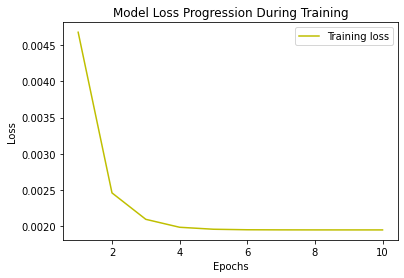

In [25]:
loss= history.history['loss']

epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')

plt.title('Model Loss Progression During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:

accuracy=history.history['accuracy']
epochs=range(1,len(loss)+1)
plt.plot(epochs,accuracy, 'r', label='Acc')
plt.title('Model  Accuracy Progression During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

NameError: ignored

In [26]:
validation_x[0].shape

(10, 11)

In [27]:
validation_x.shape
test_data = np.reshape(validation_x[0],(1, validation_x[0].shape[0], validation_x[0].shape[1]))
test_data.shape

(1, 10, 11)

In [28]:
test = model.predict(test_data)
test

1/1 [==============================] - 0s 46ms/step


array([[0.9361347 , 0.34832984]], dtype=float32)

In [29]:

print(trainPredict.shape)
print(testPredict.shape)

(205518, 2)
(11251, 2)


In [30]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.10 RMSE


In [ ]:
trainPredictPlot = np.empty_like(target)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(target)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(target)-10, :] = testPredict
# plot baseline and predictions

fig=plt.figure(figsize=(35,15))
plt.plot(trainPredictPlot[57000:])
plt.plot(testPredictPlot[57000:])
plt.show()


ValueError: ignored

In [31]:
pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


In [32]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

87950
95532
Precision:  92.06339237114265


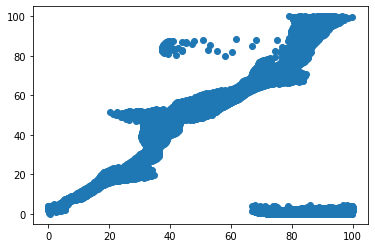

In [ ]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 8):
    correct+=1


print(correct)
print(len(actual))

print("Precision: ", correct * 100/len(actual))

In [ ]:
iter=0
error_bins={}
for p in pred:
  ind=int(actual[iter])
  # print(ind)
  error=abs((float(actual[iter])-float(pred[iter])))
  if ind not in error_bins:
    error_bins[ind]=[error]
  else:
    error_bins[ind].append(error)
  iter+=1
error_perc=[]
myKeys = list(error_bins.keys())
myKeys.sort()
sorted_e_bins = {i: error_bins[i] for i in myKeys}

num_err=[]
for key in sorted_e_bins.keys():
  error_perc.append((sum(sorted_e_bins[key]))/len(sorted_e_bins[key]))
  num_err.append(len(sorted_e_bins[key]))

In [ ]:
error_perc

[68.26059756215929,
 6.660327594465876,
 0.433041010330934,
 0.2990148430950385,
 0.3657079440738399,
 0.40891492756230474,
 0.36156229531513684,
 0.3271950053528261,
 0.30515904418797435,
 0.35660810310989416,
 0.4149606209785175,
 0.5142984643907321,
 0.6232961486319439,
 0.6884714723192611,
 0.719843773172629,
 0.7832291411166433,
 0.8899801877314586,
 0.9068038284245442,
 0.8893864505962045,
 0.8953200655980954,
 0.8930196826804828,
 0.9016210207690416,
 0.8918964881000802,
 0.9650056398588002,
 1.1262809255637123,
 1.3012366627122076,
 1.416655721699895,
 1.5207309934512447,
 1.591891218638699,
 1.6886689884302044,
 1.7750437439393698,
 1.809323243676442,
 1.8796806350916166,
 1.880110722775746,
 1.8892218266759828,
 1.858661374156767,
 1.8106171341800263,
 1.7894111699130844,
 1.6859278047334234,
 1.5789469431944008,
 1.4870026173508695,
 1.4747451672184275,
 1.5088793183293994,
 1.6170634506692225,
 1.6070373737740087,
 1.6858014297435753,
 1.7049327164380523,
 1.702899043220730

68.26059756215929
100


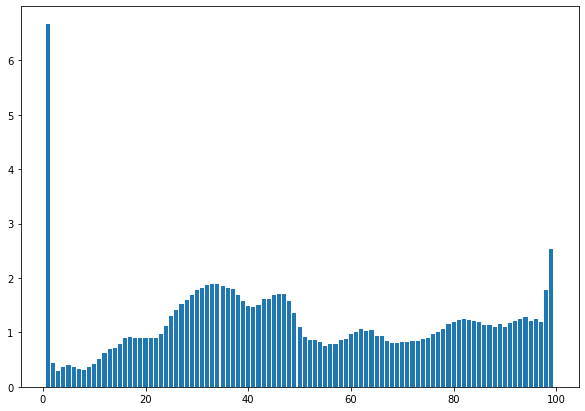

In [ ]:
print((sum(sorted_e_bins[0]))/len(sorted_e_bins[0]))
fig = plt.figure(figsize =(10, 7))
print(len(error_perc))
# Horizontal Bar Plot
plt.bar(list(range(1,100)),error_perc[1:]) 
# Show Plot
plt.show()

100


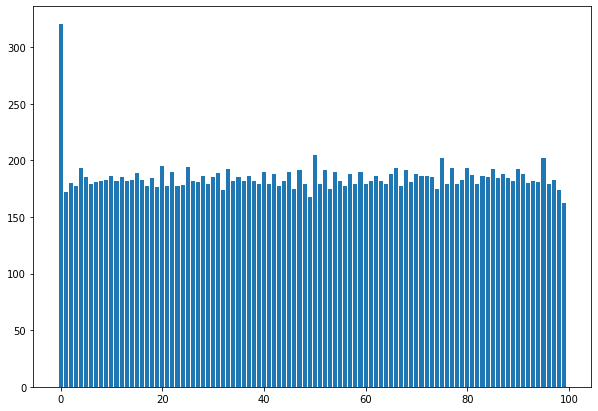

In [ ]:
fig = plt.figure(figsize =(10, 7))
print(len(error_perc))
# Horizontal Bar Plot
plt.bar(list(range(0,100)),num_err[0:]) 
# Show Plot
plt.show()

Text(0, 0.5, 'Percentage (%)')

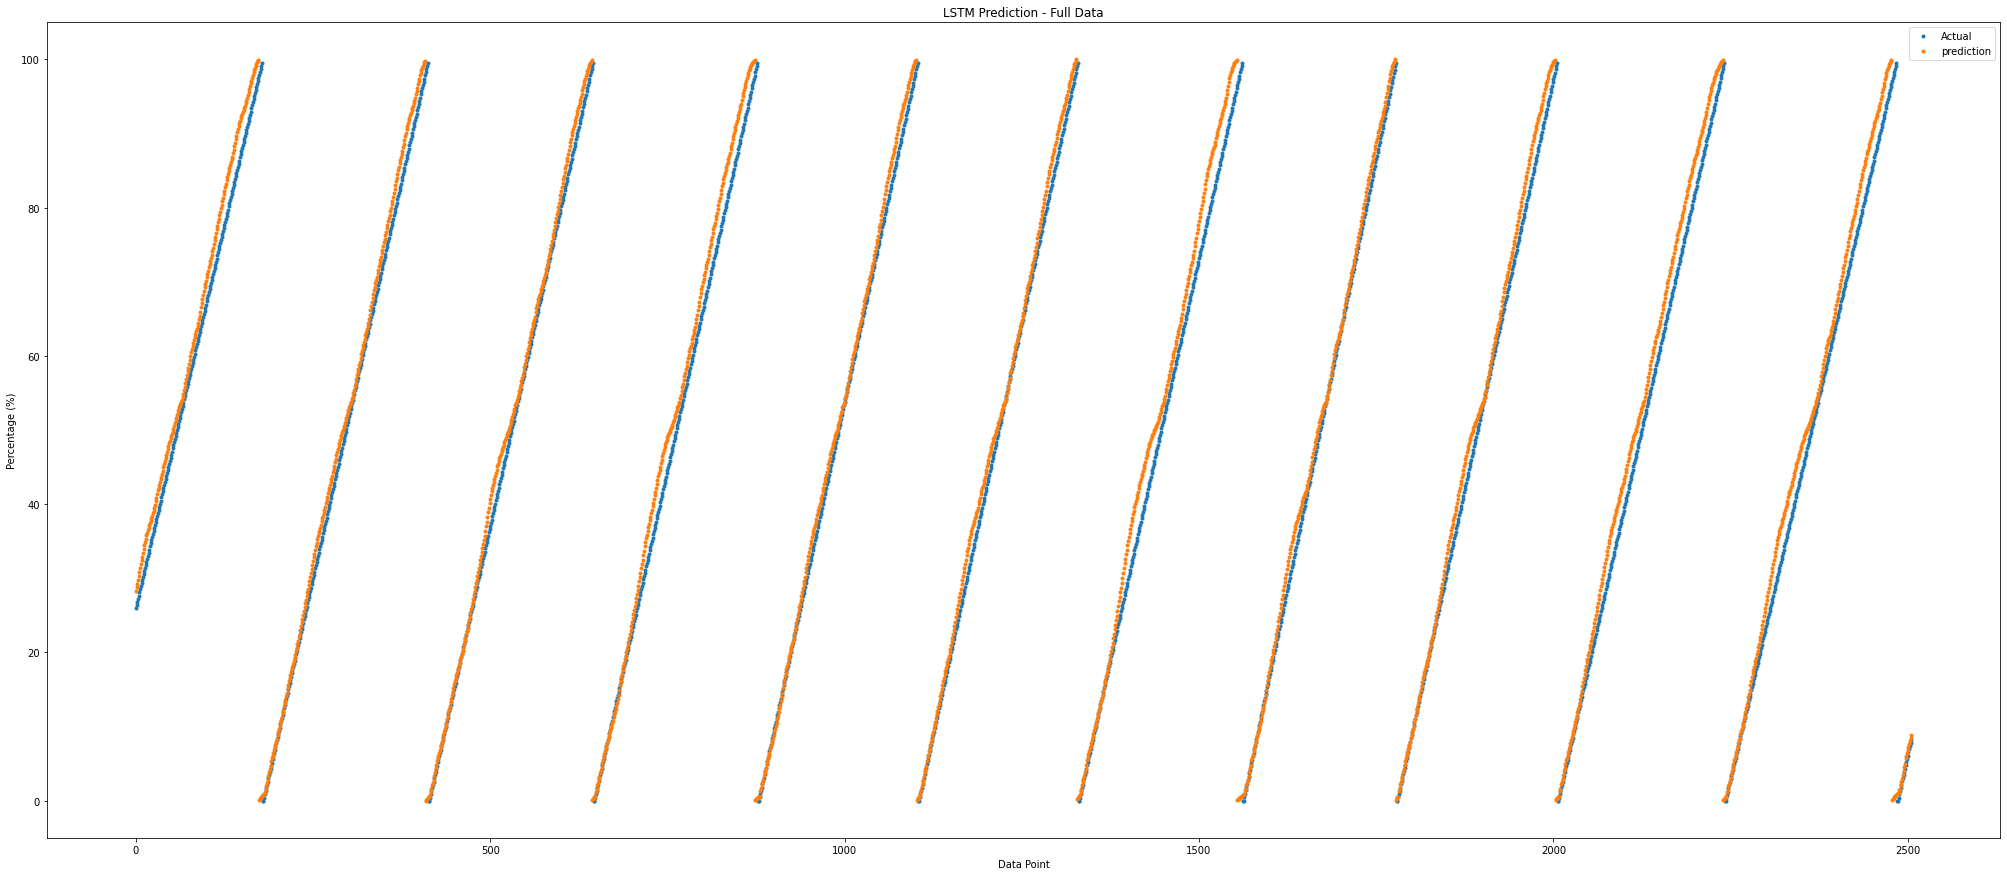

In [33]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

# plt.plot(actual2[:],'-',label='Actual', linewidth = 3)
# plt.plot(predict[:],'.-',label='prediction', linewidth = 2)



plt.plot(actual[50:2556],'.',label='Actual')
plt.plot(pred[50:2556],'.',label='prediction')

plt.legend()
plt.title('LSTM Prediction - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

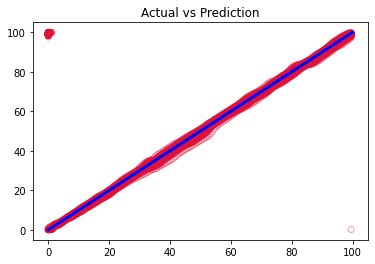

In [ ]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

**TESTING USING OTHER DATA**

In [ ]:
test_excel_name= 'SPT.xlsx' 

test_table = pd.read_excel(train_file_path2, sheet_name='raw_data')
encode_gait_percentage(test_table, 'perc')

test_table.keys()


Index(['l_hip', 'l_foot', 'l_shank', 'perc', 'l_grf', 'r_grf', 'r_hip',
       'r_foot', 'r_shank', 'X', 'Y'],
      dtype='object')

In [ ]:
data_x_test = test_table.drop(["perc", "X", "Y"], axis = 1)
target_test = test_table[["X", "Y"]]

scaler2 = MinMaxScaler()
data_test = scaler2.fit_transform(data_x_test)


In [ ]:
ratio = 0.8
training_cutoff = math.floor(ratio * len(test_table))

training_data = data_test[0:training_cutoff]
training_target = target_test[0:training_cutoff].values

validation_data = data_test[training_cutoff:-1]
validation_target = target_test[training_cutoff:-1].values

print(training_data.shape)
print(training_target.shape)
print(validation_data.shape)
print(validation_target.shape)

(34564, 8)
(34564, 2)
(8640, 8)
(8640, 2)


In [ ]:
look_back = 10
fore_cast = 1

test_x, test_y = convert_data(training_data, training_target, look_back, fore_cast)

In [ ]:
model_save_path="/content/drive/MyDrive/nmchr_lab/models/model_CNNlstm_new_data_latest_1"

model=tf.keras.models.load_model(model_save_path)

In [ ]:
test_new = model.predict(test_x)

1080/1080 [==============================] - 5s 4ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

score = np.sqrt(mean_squared_error(test_y, test_new))
print('Test Score: %.2f RMSE' % (score))

Test Score: 0.07 RMSE


In [ ]:
predict = np.zeros((len(test_new),1))

for iter in range(len(test_new)):
  x = test_new[iter][0]
  y = test_new[iter][1]
  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


In [ ]:
actual2 = np.zeros((len(test_y),1))

for iter in range(len(test_y)):
  x =test_y[iter][0]
  y =test_y[iter][1]
  actual2[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [ ]:
correct = 0
for iter in range(len(actual2)):
  if (abs(actual2[iter] - predict[iter]) <= 2):
    correct+=1

print(correct)
print(len(actual2))

print("Precision: ", correct * 100/len(actual2))

11050
76932
Precision:  14.363333853273021


In [ ]:
actual2

array([[ 3.42679128],
       [ 3.73831776],
       [ 4.04984424],
       ...,
       [44.68085106],
       [45.10638298],
       [45.53191489]])

Text(0, 0.5, 'Percentage (%)')

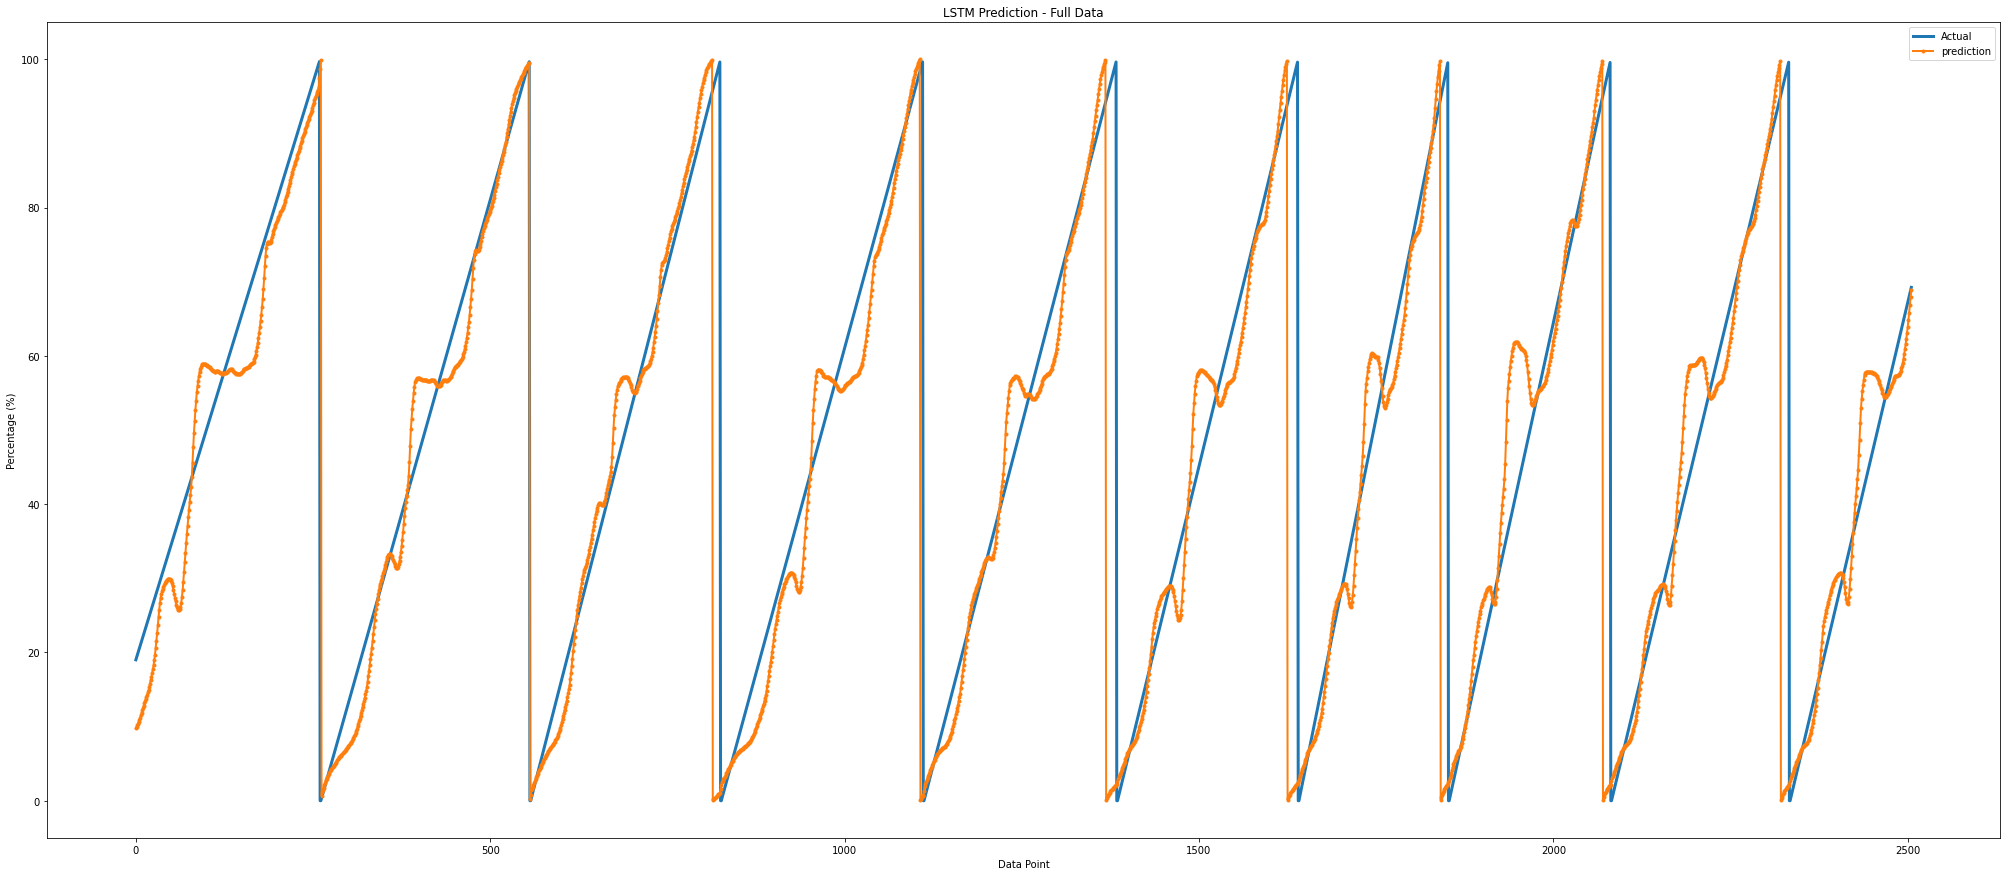

In [ ]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

plt.plot(actual2[50:2556],'-',label='Actual', linewidth = 3)
plt.plot(predict[50:2556],'.-',label='prediction', linewidth = 2)

#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('LSTM Prediction - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

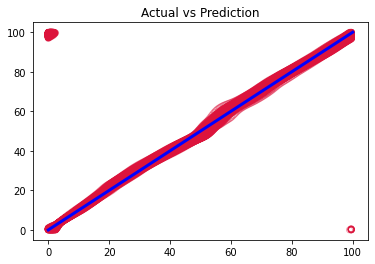

In [ ]:
plt.scatter(actual2, predict, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(predict), max(actual2))
p2 = min(min(predict), min(actual2))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
#class PolicyDataset(Dataset):
#    def __init__(self, data, target, transform=None):
#        self.data = data
#        self.target = target
        #self.label_split_idx = label_split_idx # not sure if splitting in dataset or in network is better idea.
        #self.use_cuda_if_avaiable = use_cuda_if_avaiable

#        return 
#    def __len__(self):
#        return self.data.shape[0]

#    def __getitem__(self, idx):
#        return self.data[idx, ], self.target[idx, ]

#training_dataset = PolicyDataset(training_data, training_target)
#validation_dataset = PolicyDataset(validation_data, validation_target)


In [ ]:
#class LSTM(nn.Module):
#    def __init__(self, hidden_layers=64):
#        super(LSTM, self).__init__()
#        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
#        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
#        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
#        self.linear = nn.Linear(self.hidden_layers, 2)
        
#    def forward(self, y, future_preds=0):
#        outputs, n_samples = [], y.size(0)
#        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
#        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
#        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
#        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
#        for time_step in y.split(1, dim=1):
            # N, 1
#            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
#            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
#            output = self.linear(h_t2) # output from the last FC layer
#            outputs.append(output)
            
#        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
#            h_t, c_t = self.lstm1(output, (h_t, c_t))
#            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
#            output = self.linear(h_t2)
#            outputs.append(output)
        # transform list to tensor    
#        outputs = torch.cat(outputs, dim=1)
#        return outputs

In [ ]:
# Divide data into batches: (gait cycle length) 

#num_feature = len(source_table.keys()) - 1
#num_feature

#N = 1 # Total number of gait cycles
#L = 1 # Length of longest cycle
#length = 0
#for i in range(len(source_table)):
#    length = length + 1
#    if source_table['perc'][i] == 0:
#        N = N + 1
#        if length - 1 > L:
#            L = length - 1
#        length = 1
        
#print(N)x_data = [[[0 for k in range(num_feature)] for j in range(L)] for i in range(N-1)]
#y_data = [[[0 for k in range(2)] for j in range(L)] for i in range(N-1)]
#print(pd.DataFrame(x_data).shape)
#print(x_data)
#no_gait = 0
#size = 0
#for i in range(len(source_table)):
#    if source_table['perc'][i] == 0:
#        if size == 0:
#            x_data[no_gait][size][:] = x_scaled.iloc[i]
#            y_data[no_gait][size][:] = y.iloc[i]
#            size = size + 1
#        else:
#            while size < L:
#                x_data[no_gait][size][:] = [0 in range(num_feature)]
#                y_data[no_gait][size][:] = [0 in range(2)]
#                size = size + 1
#            no_gait = no_gait + 1
#            size = 0
#    else:
#        x_data[no_gait][size][:] = x_scaled.iloc[i]
#        y_data[no_gait][size][:] = y.iloc[i]
#        size = size + 1
#        if size >= L:
#            size = 0
#            no_gait = no_gait + 1
#print(L)

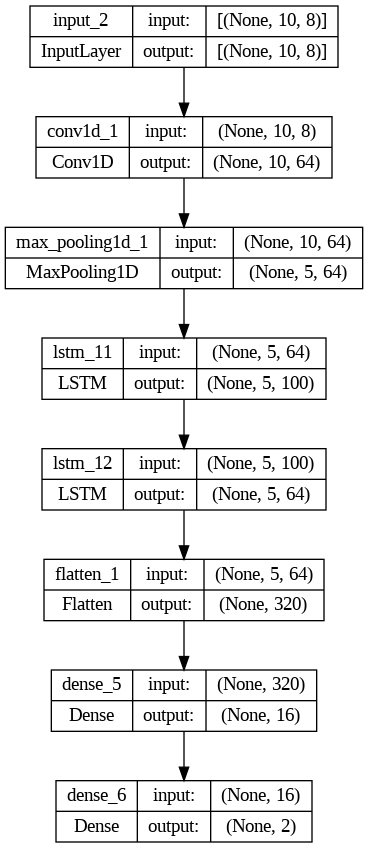

In [ ]:
model_img='/content/drive/MyDrive/nmchr_lab/Subjects/model_cnnlstm.png'

tf.keras.utils.plot_model(model, to_file=model_img, show_shapes=True)
